In [1]:
from pynq import Overlay, allocate, PL
import struct
import scipy.io.wavfile as wav

PL.reset()
overlay = Overlay('wahwah.bit')

In [2]:
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['wah_wah_filter_axi_0', 'axi_dma_0', 'processing_system7_0']


In [3]:
wahwah_filter     = overlay.wah_wah_filter_axi_0
dma_0 = overlay.axi_dma_0
dma_0_send = overlay.axi_dma_0.sendchannel
dma_0_recv = overlay.axi_dma_0.recvchannel

CONTROL_REGISTER = 0x0

def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

def float_to_hex(f):
    return struct.unpack('<I', struct.pack('<f', f))[0]

SAMPLE_RATE_REGISTER = get_register_offset(overlay, 'wah_wah_filter_axi_0', 'sample_rate')
MIN_FREQ_REGISTER = get_register_offset(overlay, 'wah_wah_filter_axi_0', 'min_freq')
MAX_FREQ_REGISTER = get_register_offset(overlay, 'wah_wah_filter_axi_0', 'max_freq')
LFO_FREQ_REGISTER = get_register_offset(overlay, 'wah_wah_filter_axi_0', 'lfo_freq')

wahwah_filter.write(SAMPLE_RATE_REGISTER, 48000)
wahwah_filter.write(MIN_FREQ_REGISTER, float_to_hex(500.0))
wahwah_filter.write(MAX_FREQ_REGISTER, float_to_hex(3000.0))
wahwah_filter.write(LFO_FREQ_REGISTER, float_to_hex(1.0))

min_freq = square_sum_0 = struct.unpack('f', struct.pack('I', wahwah_filter.read(MIN_FREQ_REGISTER)))[0]

In [4]:
def process_buffers_fpga(in_buffer, out_buffer):

    wahwah_filter.write(CONTROL_REGISTER, 0x01)
    
    dma_0_send.transfer(in_buffer)
    dma_0_recv.transfer(out_buffer)
    dma_0_send.wait()
    dma_0_recv.wait()

def process_fpga(raw_data):
    
    in_buffer = allocate(shape=(len(raw_data),), dtype=raw_data.dtype)
    out_buffer = allocate(shape=(len(raw_data),), dtype=raw_data.dtype)
    
    in_buffer[:] = raw_data[:]
    
    process_buffers_fpga(in_buffer, out_buffer)
    
    return out_buffer

In [6]:
%matplotlib inline
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft

wav_path = "PinkPanther30.wav"
#with wave.open(wav_path, 'r') as wav_file:
#    raw_frames = wav_file.readframes(-1)
#    num_frames = wav_file.getnframes()
#    num_channels = wav_file.getnchannels()
#    sample_rate = wav_file.getframerate()
#    sample_width = wav_file.getsampwidth()
        
#temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
#raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
#temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
#                                                    sample_width)
#temp_buffer[:, :, sample_width:] = \
#    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
#frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

sample_rate, input_signal = wav.read(wav_path)
num_channels = len(input_signal.shape)
num_frames = input_signal.shape[0]
frames = np.int32(input_signal)
frames = frames[..., np.newaxis]

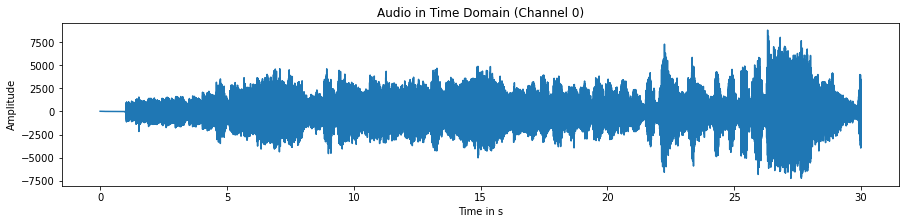

In [7]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, frames[:, channel_index])
    plt.show()

In [8]:
filtered_data = []
for i in range(num_channels):
    filtered = process_fpga(frames[:, 0])
    filtered_data.append(filtered)

In [9]:
filtered_signal_scaled = np.int32(filtered_data[0] * 2147483648.0 / 32768.0)
wav.write("output.wav", sample_rate, filtered_signal_scaled)

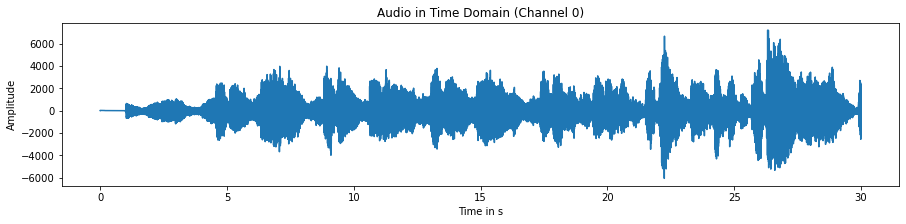

In [10]:
for channel_index in range(num_channels):
    plt.figure(num=None, figsize=(15, 3))
    plt.title('Audio in Time Domain (Channel {})'.format(channel_index))
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
    plt.plot(time_axis, filtered_data[channel_index])
    plt.show()